In [1]:
# import pykeops
# pykeops.clean_pykeops()          # just in case old build files are still present
# pykeops.test_numpy_bindings()    # perform the compilation

In [186]:
import os
import torch, pyro, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)
from torch import tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
from tqdm import tqdm


from clipppy import load_config, Clipppy
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML

import swyft
import pyro.distributions as dist

import matplotlib.pyplot as plt
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')

import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *

plt.rcParams.update({'font.size': 22})


DEVICE = 'cuda'

In [3]:
RUN = '_m12_nsub5'
nsubstring = '-5'


SYSTEM_NAME = "ngc4414"

NSIM = 10000
# NSIM = 100
# SIM_PATH = f'/nfs/scratch/eliasd/store.zarr' 
SIM_PATH = f'/nfs/scratch/eliasd/store{RUN}.zarr' 

# UNet =  f'UNet{RUN}.pt'

# UNet =  f'UNet-test.pt'

SIGMA = 0.1

### Utilities

In [4]:
def get_config(system_name: str, nsub: str = '') -> Clipppy:
    """
    Get configuration
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

    SOURCE_DIR = '../../mock_data/sources'
        
    source_name = f'{system_name}.npy'
    config = load_config(f'config-sub{nsub}.yaml', base_dir=SOURCE_DIR)

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return config


def get_prior(config: Clipppy):
    """
    Set up subhalo parameter priors using a config
    """
    main = config.umodel.alphas["main"]
    prior_p_sub = main.sub.pos_sampler.base_dist
    lows = np.array(
        [
            prior_p_sub.low[0].item(),
            prior_p_sub.low[1].item(),
        ]
    )
    highs = np.array(
        [
            prior_p_sub.high[0].item(),
            prior_p_sub.high[1].item(),
        ]
    )
    
    nsub = main.sub.nsub
    lows = np.tile(lows, nsub)
    highs = np.tile(highs, nsub)
    
    uv = lambda u: (highs - lows) * u + lows
    
    return swyft.Prior(uv, nsub*2), uv
#     return swyft.Prior(uv, 2), uv


def simul(v, config: Clipppy):
    """
    Fix values for main lens and source parameters from config and put
    in a subhalo with the specified position and mass.

    Arguments
    - v: array containing x_sub, y_sub.

    Returns
    - Numpy array.
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
    
    from pyrofit.lensing.utils import get_meshgrid  # import here due to HACKs
    nx = config.kwargs["defs"]["nx"]
    ny = config.kwargs["defs"]["ny"]
    res = config.kwargs["defs"]["res"]
    nsub = config.umodel.alphas["main"].sub.nsub
    X, Y = config.umodel.X.clone(), config.umodel.Y.clone()
    # Upsample image
    upsample = 10
    config.umodel.coerce_XY(*get_meshgrid(res / upsample, nx * upsample, ny * upsample))
        
    if not torch.is_tensor(v):
        v = torch.tensor(v)

    xy_sub = v.view(-1,2).to(DEVICE)
    d_p_sub = dist.Delta(xy_sub).to_event(1)
    
#     x_sub, y_sub = np.squeeze(v.T)
#     d_p_sub = dist.Delta(torch.tensor([x_sub, y_sub])).to_event(1)


    def _guide():
        # Sample subhalo position
        guide_sample = {
            "main/sub/p_sub": pyro.sample("main/sub/p_sub", d_p_sub),
        }

        return guide_sample
    
    result = {
        "image": CONFIG.ppd(guide=_guide)["model_trace"]
        .nodes["mu"]["value"]
        .detach()
        .numpy()
    }
    
    # Restore coarse grid
    config.umodel.coerce_XY(X, Y)
    # Downsample image
    averager = torch.nn.AvgPool2d((upsample, upsample))
    result['image'] = (averager(torch.tensor(result['image']).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0))

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return result

def noise(obs, _=None, sigma_n=SIGMA):
    image = obs["image"]
    eps = np.random.randn(*image.shape) * sigma_n
    return {"image": image + eps}


### Check utilities

In [5]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
CONFIG = get_config(SYSTEM_NAME, nsubstring)
torch.set_default_tensor_type(torch.FloatTensor)

In [6]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
ppd = CONFIG.ppd()['model_trace'].nodes
torch.set_default_tensor_type(torch.FloatTensor)

tensor([[ 2.2090, -2.2572],
        [-1.2353, -0.2152],
        [ 0.1992, -1.7111],
        [ 0.0060, -1.4463],
        [-2.1585, -1.8489]], device='cuda:0')
{'image': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')}


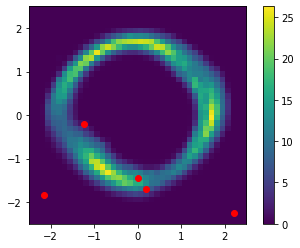

In [7]:
v = ppd['main/sub/p_sub']['value']
sim = simul(v, CONFIG)

print(v)
print(sim)

plt.scatter(*v.t(), c="r")
plt.imshow(simul(v, CONFIG)['image'], **imkwargs)
plt.colorbar()
plt.show()

In [8]:
torch.sum(np.abs(simul(v, CONFIG)['image'] - simul(v, CONFIG)['image']))

tensor(0.)

### Simulate

In [9]:
prior, uv = get_prior(CONFIG)
nx = CONFIG.kwargs["defs"]["nx"]
ny = CONFIG.kwargs["defs"]["ny"]
nsub = CONFIG.umodel.alphas["main"].sub.nsub
print(f'nsub = {nsub}')

nsub = 5


In [10]:
pnames = [f'{z}_{i+1}' for i in range(nsub) for z in ['x', 'y']]
print(pnames)
simulator = swyft.Simulator(model = lambda v: simul(v, CONFIG), 
#                             pnames = ["x_sub", "y_sub"],
                            pnames = pnames,
                            sim_shapes={"image": (nx, ny)})

store = swyft.DirectoryStore(path=SIM_PATH, simulator=simulator)
# store = swyft.MemoryStore(simulator=simulator)

store.add(NSIM, prior)
store.simulate()

['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3', 'x_4', 'y_4', 'x_5', 'y_5']
Loading existing store.


### Check store

In [11]:
# store = swyft.DirectoryStore(path=SIM_PATH)
len(store)

10128

In [12]:
N = 90
coords_x = np.array([store[i][1][0::2] for i in range(N)])
coords_y = np.array([store[i][1][1::2] for i in range(N)])
imgs = np.array([store[i][0]['image'] for i in range(N)])

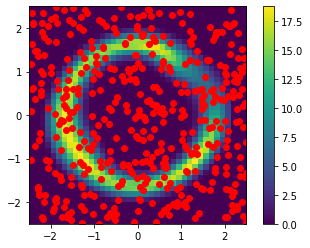

In [13]:
plt.imshow(np.mean(imgs, axis = 0), **imkwargs)
plt.colorbar()
# plt.scatter(coords[:,0], coords[:,1], c = 'r')
plt.scatter(coords_x.flatten(), coords_y.flatten(), c = 'r')
plt.show()

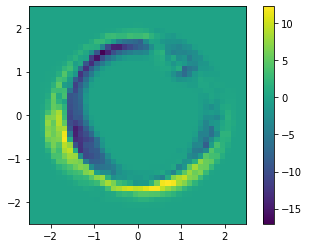

In [14]:
plt.imshow(store[1][0]['image']-store[-1][0]['image'], **imkwargs)
plt.colorbar()

### Train

In [15]:
idx = 0
img_0 = store[idx][0]['image']
L1, L2 = tensor(img_0.shape)
assert L1 == L2
L = L1.item()
print(f'L = {L}')

L = 40


In [16]:
torch.set_default_tensor_type(torch.FloatTensor)
dataset = swyft.Dataset(NSIM, prior, store)#, simhook = noise)
marginals = [i for i in range(L**2)]
# post = swyft.Posteriors(dataset)

In [17]:
def coord_uv(coords_u, lows, highs):
#     highs_l = np.repeat(highs, coords_u)
#     lows_l = np.repeat(lows, coords_u)
    highs_l = np.full_like(coords_u, highs)
    lows_l = np.full_like(coords_u, lows)
    
    v = lambda u: (highs_l - lows_l) * u + lows_l
    coords_v = v(coords_u)
    return coords_v

def coord_to_map(XY_u):
    
    y0, y1, x0, x1 = -2.5, 2.5, -2.5, 2.5
    lows, highs = -2.5, 2.5
    res = 0.125
    
    XY = XY_u
    
    n_batch =  XY.shape[0]
    n_coords = XY.shape[1]
        
    binary_map = torch.zeros((n_batch, L,L), device = DEVICE)
    
    x, y = XY[:,0::2], XY[:,1::2]
    
    x_i = torch.floor((x*L).flatten()).type(torch.long) 
    y_i = torch.floor((y*L).flatten()).type(torch.long) 

    if n_coords != 0:
        i   = torch.floor(torch.arange(0, n_batch, 1/n_coords*2).to(DEVICE)).type(torch.long) 
    
        xx = tuple(torch.stack((i, y_i, x_i)))
        binary_map[xx] = 1

    return binary_map
    

class DoubleConv(swyft.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False), # bias = False becaise BatchNorm2d is set
            nn.BatchNorm2d(out_channels), # BatchNorm2d were not known when paper came out
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(swyft.Module):
    def __init__(self, n_features, marginals):
        super().__init__(n_features, marginals) 
#         super(UNET, self).__init__()
        
        self.marginals = marginals
        self.n_features = n_features
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # keep size the same
        
        in_channels=1
        out_channels=2
        features=[64, 128, 256, 512]

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        

    def forward(self, sims, target):
                
        sims = sims.view(-1, L, L)
        z = coord_to_map(target)
    
        ############# UNet Start ###
        x = sims
        n_batch = len(x)
        x = x.unsqueeze(1)
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverse list

        # the upsampling
        for idx in range(0, len(self.ups), 2): # step of 2 because we want up - double column - up - double column
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2] # //2 because we want still steps of one

            # if statement because we can put in shapes that are not divisble by two around 19:00 of video
            if x.shape != skip_connection.shape: 
                x = TF.resize(x, size=skip_connection.shape[2:]) # hopefully does not impact accuracy too much

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        x = self.final_conv(x)
        ############# UNet End ###

        
                
        # L[C]
        x_new = x[:,0] * (1 - z) + x[:,1] * z
        
        
#         if len(x) != 0:
            
#             u = target[0]
#             v = coord_uv(target[0].numpy(), -1, 1)

        
#             plt_imshow([x[0][0], x[0][1], x_new[0], z[0], z2[0]], 
#                        titles = ['lnr0', 'lnr1', 'lnr[z]', 'z', 'z2'],
# #                        scatter = [v],
#                        cbar = True, size_y = 3, **imkwargs)
        
        x = x_new
        x = x.view(-1, self.n_features)
        return x

class CustomHead(swyft.Module):

    def __init__(self, obs_shapes) -> None:
        super().__init__(obs_shapes=obs_shapes)
        self.n_features = torch.prod(tensor(obs_shapes['image']))

    def forward(self, obs) -> torch.Tensor:
        x = obs["image"]
        n_batch = len(x)
        x = x.view(n_batch, self.n_features)
        return x

In [201]:
lrs = np.logspace(-5, -3, 5)
factors = np.logspace(-4, -1, 5)
patiences = np.array([2, 4])

mesh = np.stack(np.meshgrid(lrs, factors, patiences), -1).reshape(-1, 3)
n_mesh = len(mesh)



In [209]:
save_names = []
save_paths = []

for i, (lr, fac, pat) in enumerate(mesh):
        
    save_id = f'lr{np.log10(lr)}_fac{np.log10(fac)}_pat{pat}'
    save_name = f'UNet_{save_id}.pt'
    save_path = os.path.join('posts', save_name)
    
    save_names.append(save_name)
    save_paths.append(save_path)
    
#     print(f'Training {save_name}! \t {i+1}/{n_mesh}')
    
#     torch.set_default_tensor_type(torch.FloatTensor)
#     post = swyft.Posteriors(dataset)
#     post.add(marginals, device = DEVICE, head = CustomHead, tail = UNET)
#     post.train(marginals, #max_epochs = 3,
#                optimizer_args = dict(lr=lr),
#                scheduler_args = dict(factor=fac, patience=pat)
#               )
    
#     post.save(save_path)
#     print()

# n_mesh = len(os.listdir('posts')[1:])
# mesh = mesh[:n_mesh]
# save_names = save_names[:n_mesh]
# save_paths = save_paths[:n_mesh]

In [20]:
# # if UNet not in os.listdir() or UNet == 'UNet-test.pt':
#     print(f'Training {UNet}!')

#     torch.set_default_tensor_type(torch.FloatTensor)
#     marginals = [i for i in range(L**2)]
#     post = swyft.Posteriors(dataset)
#     post.add(marginals, device = DEVICE, head = CustomHead, tail = UNET)
#     post.train(marginals, max_epochs = 10,
#                optimizer_args = dict(lr=3e-5)
# #                scheduler_args = dict(factor=5e-4, patience=2)
#               )
#     post.save(UNet)

# print(f'Loading {UNet}!')  
# post = swyft.Posteriors.load(UNet).to(DEVICE)

In [33]:
i = np.random.randint(n_mesh)
print(f'Loading {save_names[i]}!')  
post = swyft.Posteriors.load(save_paths[i]).to(DEVICE)

Loading UNet_lr-4.0_fac-3.25_pat4.0.pt!


In [237]:
n_mesh

50

In [238]:
import pandas as pd

{'name': ['UNet_lr-5.0_fac-4.0_pat2.0.pt',
  'UNet_lr-5.0_fac-4.0_pat4.0.pt',
  'UNet_lr-4.5_fac-4.0_pat2.0.pt',
  'UNet_lr-4.5_fac-4.0_pat4.0.pt',
  'UNet_lr-4.0_fac-4.0_pat2.0.pt',
  'UNet_lr-4.0_fac-4.0_pat4.0.pt',
  'UNet_lr-3.5_fac-4.0_pat2.0.pt',
  'UNet_lr-3.5_fac-4.0_pat4.0.pt',
  'UNet_lr-3.0_fac-4.0_pat2.0.pt',
  'UNet_lr-3.0_fac-4.0_pat4.0.pt',
  'UNet_lr-5.0_fac-3.25_pat2.0.pt',
  'UNet_lr-5.0_fac-3.25_pat4.0.pt',
  'UNet_lr-4.5_fac-3.25_pat2.0.pt',
  'UNet_lr-4.5_fac-3.25_pat4.0.pt',
  'UNet_lr-4.0_fac-3.25_pat2.0.pt',
  'UNet_lr-4.0_fac-3.25_pat4.0.pt',
  'UNet_lr-3.5_fac-3.25_pat2.0.pt',
  'UNet_lr-3.5_fac-3.25_pat4.0.pt',
  'UNet_lr-3.0_fac-3.25_pat2.0.pt',
  'UNet_lr-3.0_fac-3.25_pat4.0.pt',
  'UNet_lr-5.0_fac-2.5_pat2.0.pt',
  'UNet_lr-5.0_fac-2.5_pat4.0.pt',
  'UNet_lr-4.5_fac-2.5_pat2.0.pt',
  'UNet_lr-4.5_fac-2.5_pat4.0.pt',
  'UNet_lr-4.0_fac-2.5_pat2.0.pt',
  'UNet_lr-4.0_fac-2.5_pat4.0.pt',
  'UNet_lr-3.5_fac-2.5_pat2.0.pt',
  'UNet_lr-3.5_fac-2.5_pat4.0.pt',
  

In [267]:
df = pd.DataFrame({'name': save_names, 'path' : save_paths, 'lr' : mesh[:,0], 'factor' : mesh[:,1], 'patience' : mesh[:,2]})

epochs = []
tls    = []
vls    = []

losses = {}


for i in tqdm(range(n_mesh)):
    post = swyft.Posteriors.load(save_paths[i]).to(DEVICE)
    epoch, tl, vl = get_losses(post)
    losses.update( {save_names[i] : {'epoch' : epoch, 'tl' : tl, 'vl' : vl}} )
    epochs.append(epoch)
    tls.append(tl)
    vls.append(vl)

df['epoch'] = epochs
df['tl'] = tls
df['vl'] = vls

100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


In [268]:
df['tl_finals'] = np.array([tl[-1] for tl in tls])
# tl_finals -= tl_finals.min()

df['vl_finals'] = np.array([vl[-1] for vl in vls])
# vl_finals -= vl_finals.min()

df['n_epochs'] = np.array([len(epoch) for epoch in epochs])

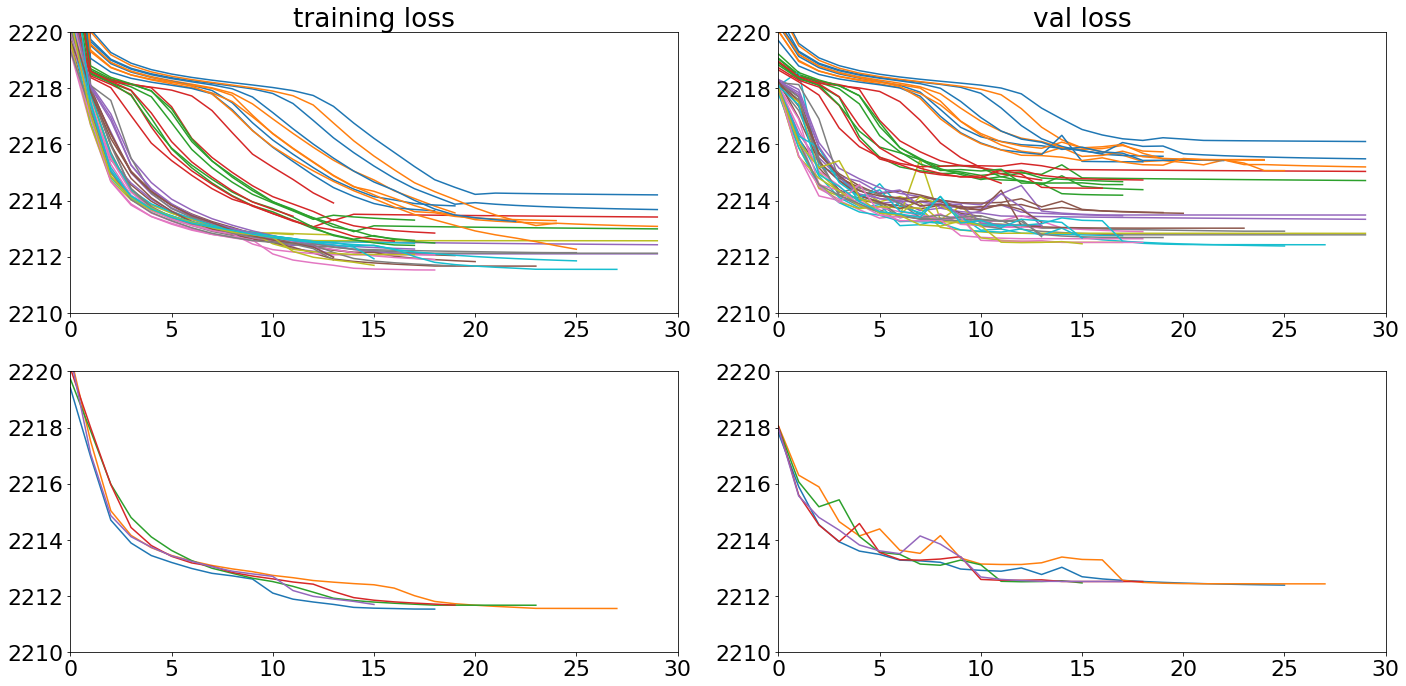

In [333]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10))

axs = axs.ravel().tolist()

for index, row in df.iterrows():
    axs[0].plot(row['epoch'], row['tl'])
    axs[1].plot(row['epoch'], row['vl'])
    
for index, row in df.sort_values(by = ['tl_finals'])[:5].iterrows():
    axs[2].plot(row['epoch'], row['tl'])
for index, row in df.sort_values(by = ['vl_finals'])[:5].iterrows():
    axs[3].plot(row['epoch'], row['vl'])
    
for ax in axs:
    ax.set_ylim(2210, 2220)
    ax.set_xlim(0, 30)

axs[0].set_title('training loss')
axs[1].set_title('val loss')

plt.tight_layout()
plt.show()


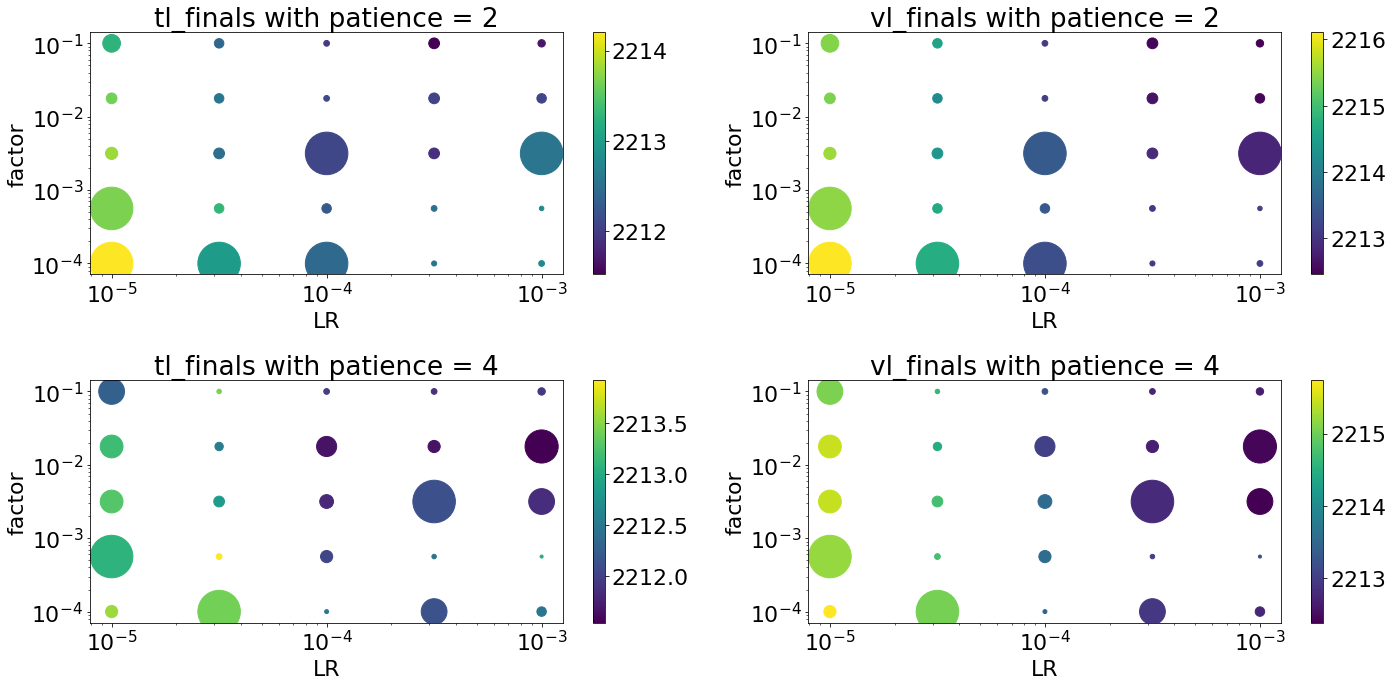

In [284]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10))

axs = axs.ravel().tolist()

i = 0

for p in ['2', '4']:
    for l in ['tl_finals', 'vl_finals']:
        
        ax = axs[i]
        i += 1
        
        df_pat = df[df['patience'] == int(p)]


        x = df_pat['lr']
        y = df_pat['factor']
        c = df_pat[l]
        s = np.exp(df_pat['n_epochs']/4)

        im = ax.scatter(x, y, s = s, c = c)

        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.set_title(f'{l} with patience = {p}')
        ax.set_xlabel('LR')
        ax.set_ylabel('factor')

        plt.colorbar(im, ax = ax)

plt.tight_layout()
plt.show()


In [366]:
posts = []
df_best = df.sort_values(by = ['vl_finals'])[:5]
for save_path in df_best['path']:
    post = swyft.Posteriors.load(save_path).to(DEVICE)
    posts.append(post)

20 20 20


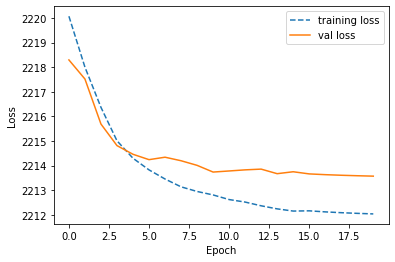

In [43]:
def get_losses(post):
        
    keys = list(post._ratios.keys())
    assert len(keys) == 1
    losses = post._ratios[keys[0]]._train_diagnostics
    assert len(losses) == 1
    tl = losses[0]['train_loss']
    vl = losses[0]['valid_loss']
    epochs = np.arange(len(tl))
    return epochs, tl, vl

def plot_losses(post):
    fig, ax = plt.subplots(1, 1)
    
    epochs, tl, vl = get_losses(post)
        
    ax.plot(epochs, tl, '--', label = f'training loss')
    ax.plot(epochs, vl, '-', label = f'val loss')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
#     ax.set_yscale('log')
    plt.legend()
    plt.show()
      
plot_losses(post)

### UNet posteriors

In [23]:
grid = torch.linspace(0,(L-1)/L,L)
x, y = torch.meshgrid(grid, grid, indexing = 'xy')
xy_full = torch.transpose(torch.stack((x.flatten(), y.flatten())), 0, 1).flatten()
xy_empty = tensor(())

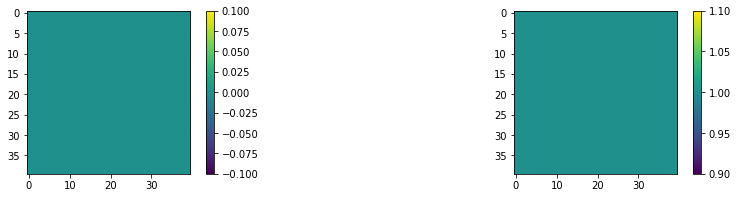

In [24]:
plots = [coord_to_map(xy.view(1, -1).to(DEVICE)).cpu().squeeze() for xy in [xy_empty, xy_full]]
plt_imshow(plots, cbar = True, size_y = 3)

In [343]:
def ratio(w):
    r = np.zeros((L**2))
    for i, (key, value) in enumerate(w.items()):
        r[i] = value
    return r.T.reshape(L, L)

def get_ratio(post, obs0, coords):
    samples = post.sample_elias(N = 1, obs0 = (obs0), n_batch = 1, v = coords.view(1, -1))
    v = samples['v']
    w = samples['weights']
    return ratio(w)

In [382]:
obs0s = []
v0s   = []
for i in np.random.randint(0, len(store), 3):
    obs0 = store[i][0]
    v0 = store[i][1]
    obs0s.append(obs0)
    v0s.append(v0)

In [387]:
patiences

array([2, 4])

In [386]:
factors

array([0.0001    , 0.00056234, 0.00316228, 0.01778279, 0.1       ])

In [385]:
lrs

array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03])

lr = 0.001, factor = 0.0031622776601683794, patiene = 4.0


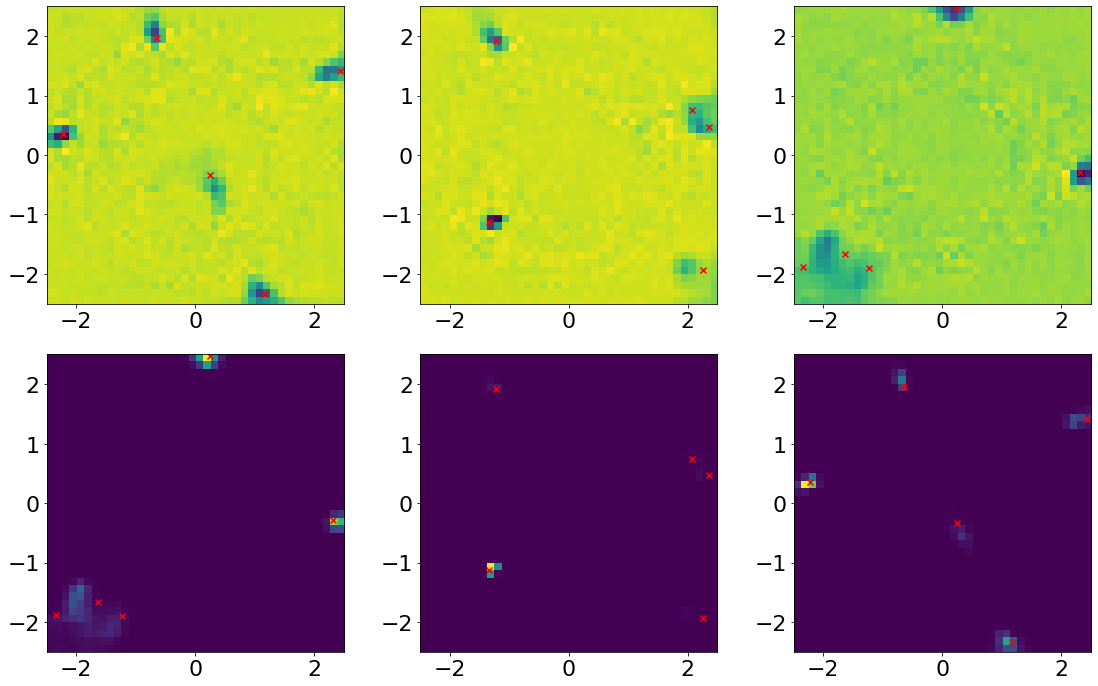

lr = 0.001, factor = 0.01778279410038923, patiene = 4.0


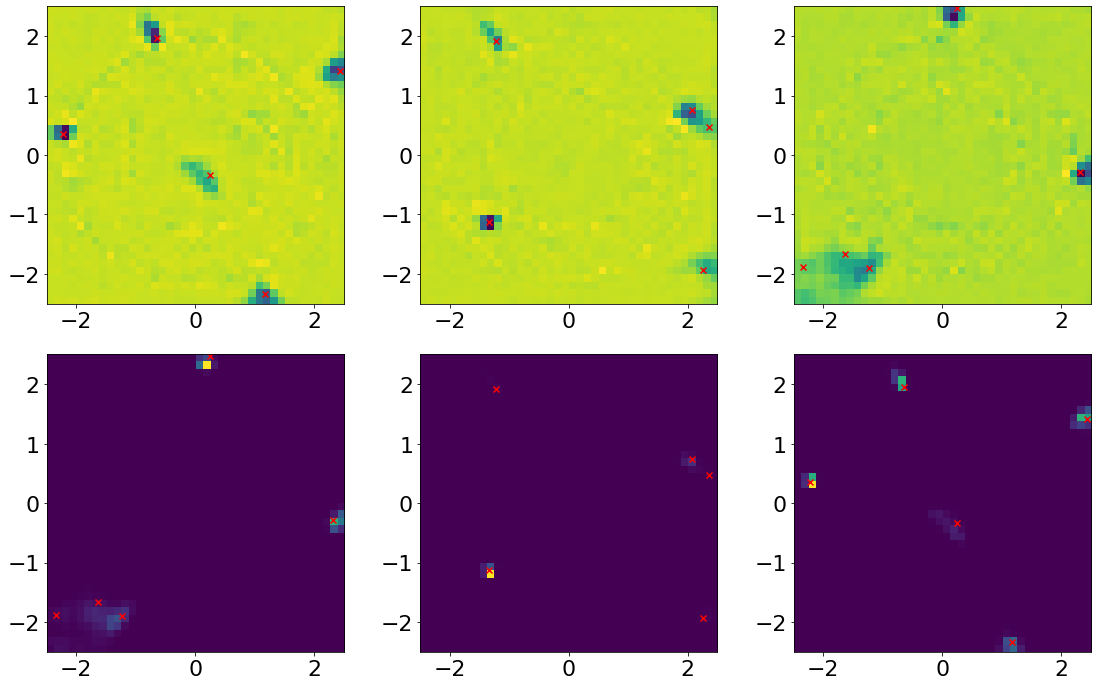

lr = 0.001, factor = 0.1, patiene = 2.0


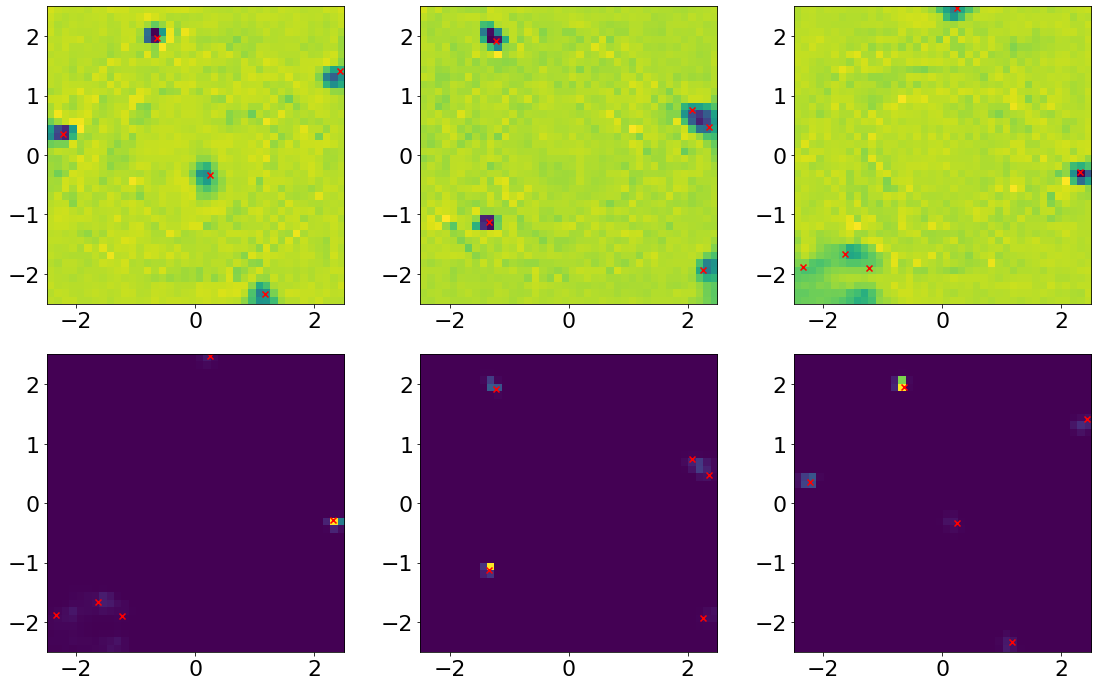

lr = 0.00031622776601683794, factor = 0.1, patiene = 2.0


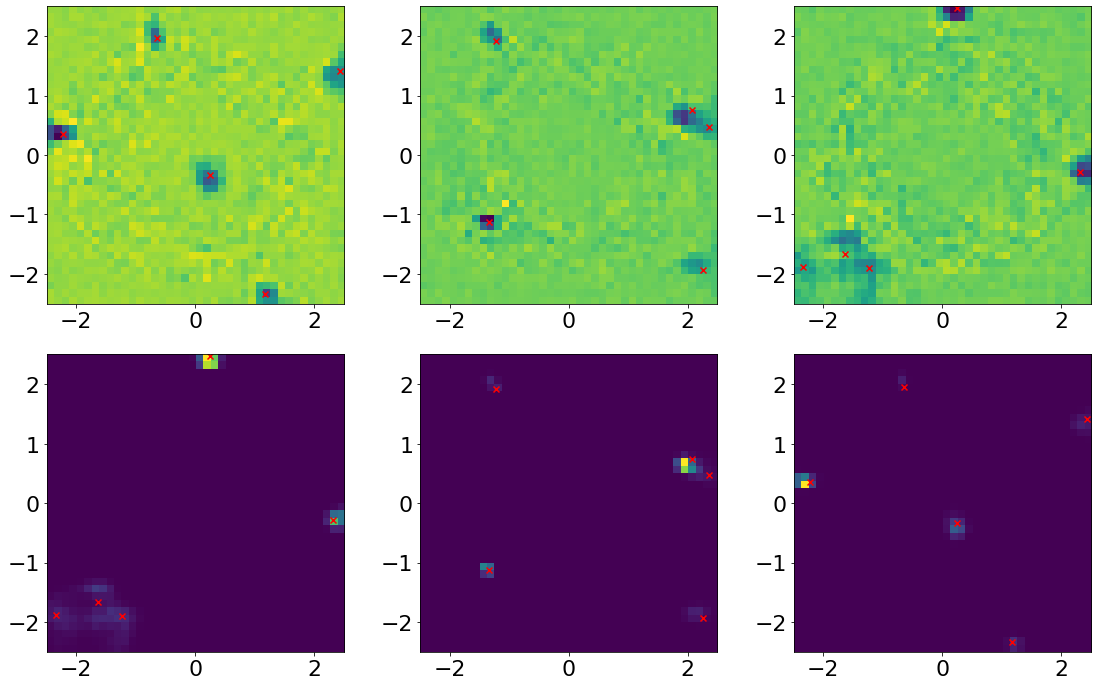

lr = 0.001, factor = 0.01778279410038923, patiene = 2.0


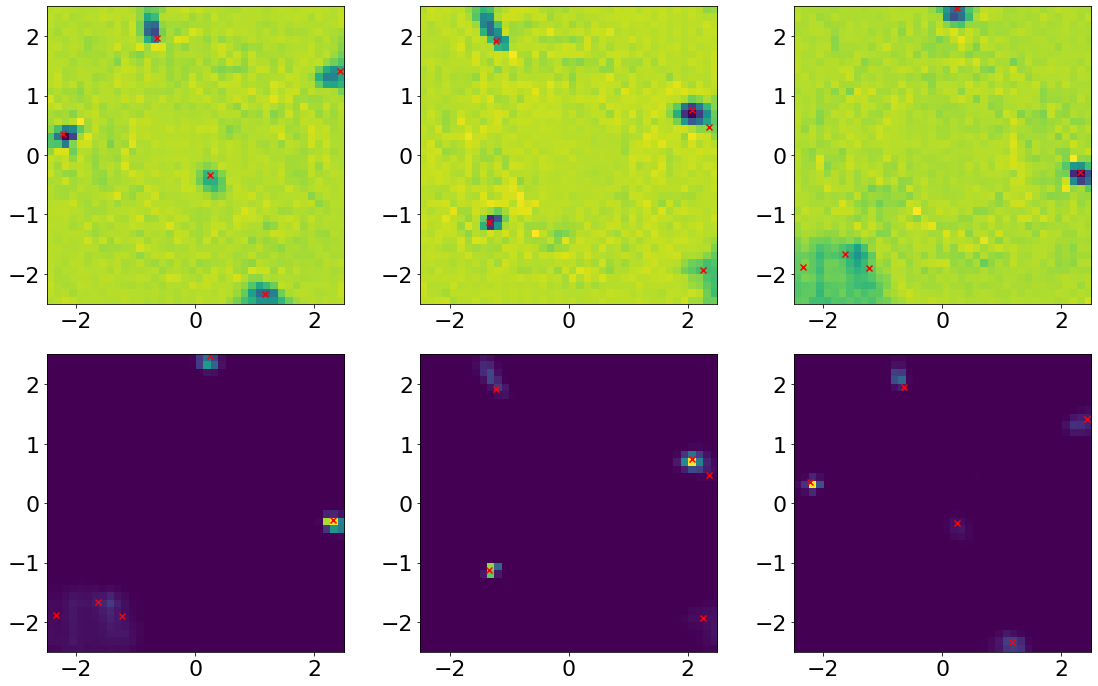

In [383]:
for post, hp in zip(posts, df_best[['lr', 'factor', 'patience']].values):
    
    lr, factor, patience = hp
    print(f'lr = {lr}, factor = {factor}, patiene = {patience}')
    
    plots = []
    
    p_0s = []
    p_1s = []
    
    ps = []
    cs = []
    
    for obs0, v0 in zip(obs0s, v0s):
        
        
        p_0 = get_ratio(post, obs0, xy_empty)/(L*L)
        p_1 = get_ratio(post, obs0, xy_full)/(L*L)
        
        ps.insert(0, p_0)
        ps.append(p_1)
        cs.insert(0, v0)
        cs.append(v0)
    
    plt_imshow(ps, 2, scatter = cs, size_y = 10, tl = True, **imkwargs)
        
    
            
        
    

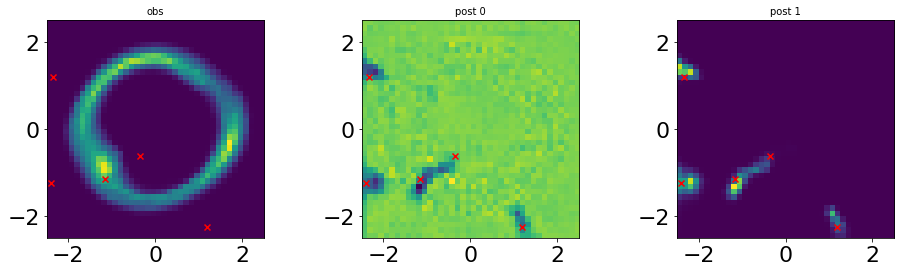

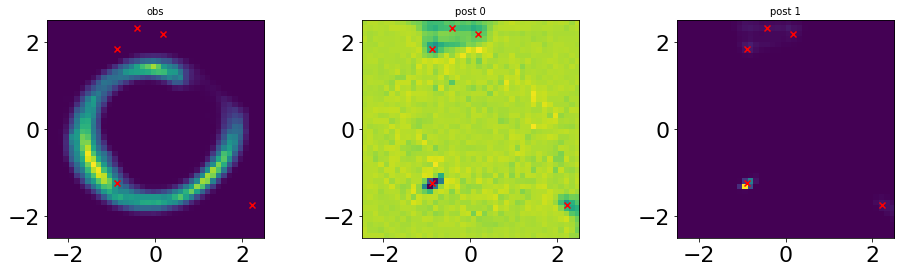

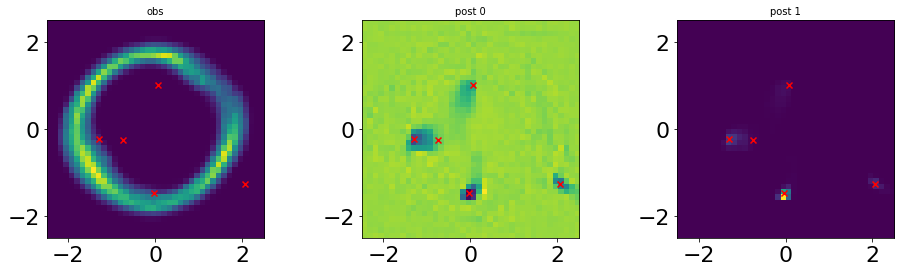

In [344]:
torch.set_default_tensor_type(torch.FloatTensor)  # HACK
# post = swyft.Posteriors.load(UNet).to(DEVICE)

p_1s = []
v0s  = []
for i in np.random.randint(0, len(store), 3):
    obs0 = store[i][0]
    v0 = store[i][1]
    
    p_0 = get_ratio(post, obs0, xy_empty)/(L*L)
    p_1 = get_ratio(post, obs0, xy_full)/(L*L)
    
    plots = [obs0['image'], p_0, p_1]
    plt_imshow(plots, titles = ['obs', 'post 0', 'post 1'], scatter = [v0]*len(plots), size_y = 4, **imkwargs)
        
    p_1s.append(p_1)
    v0s.append(v0)
    
    
    plt.show()
        
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

In [27]:
# plt_imshow([p_1s[0] - p_1s[1], p_1s[0] - p_1s[2], p_1s[1] - p_1s[2]], cbar = True, scatter = np.array([np.array(v0s).T]*3), **imkwargs)